<a href="https://colab.research.google.com/github/sibimathews3010/Fault-detection-using-Guided-images/blob/main/sIMPLE_gUIDED_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from google.colab.patches import cv2_imshow


In [ ]:

# Define the path to the directory containing the class folders
data_dir = '/content/drive/MyDrive/dataset  new approch'

# Define the image size for resizing
image_size = (224, 224)  # VGG16 input size

# Define the class labels
class_labels = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'class10', 'class11']

# Load the dataset
data = []
labels = []
for i, class_label in enumerate(class_labels):
    class_dir = os.path.join(data_dir, class_label)
    for image_file in os.listdir(class_dir):
        if image_file.endswith('.bmp'):
            image_path = os.path.join(class_dir, image_file)
            image = cv2.imread(image_path)

            # Resize the image
            resized_image = cv2.resize(image, image_size)

            data.append(resized_image)
            labels.append(i)

# Convert the data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Shuffle the dataset
data, labels = shuffle(data, labels, random_state=42)

# Preprocess the input images for VGG16
data = preprocess_input(data)

# Load the pre-trained VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Extract features from the pre-trained model
features = vgg16_model.predict(data)

# Initialize Guided Grad-CAM directory
guided_cam_data_dir = '/content/drive/MyDrive/GuidedCamDataset'
os.makedirs(guided_cam_data_dir, exist_ok=True)




12/12 [==============================] - 253s 21s/step


In [ ]:
def get_grad_cam(model, image, class_index, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    return heatmap.numpy()


In [ ]:
def generate_guided_grad_cam(image, last_conv_layer_name='block5_conv3'):
    # Load VGG16 model with pre-trained weights
    vgg16_model = VGG16(weights='imagenet')
    vgg16_model.layers[-1].activation = tf.keras.activations.softmax

    # Preprocess the image for VGG16
    preprocessed_image = preprocess_input(image)

    # Get the class index for the predicted class
    class_index = np.argmax(vgg16_model.predict(np.expand_dims(preprocessed_image, axis=0))[0])

    # Generate the Grad-CAM heatmap
    heatmap = get_grad_cam(vgg16_model, np.expand_dims(preprocessed_image, axis=0), class_index, last_conv_layer_name)

    # Resize the heatmap to match the image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Convert heatmap to BGR for visualization
    heatmap_bgr = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    # Overlay the heatmap on the original image
    superimposed_image = cv2.addWeighted(image, 0.6, heatmap_bgr, 0.4, 0)

    return superimposed_image

In [ ]:
import gc

In [ ]:
# Load the dataset
for class_label in class_labels:
    class_dir = os.path.join(data_dir, class_label)
    for image_file in os.listdir(class_dir):
        if image_file.endswith('.bmp'):
            image_path = os.path.join(class_dir, image_file)
            image = cv2.imread(image_path)

            # Resize the image
            resized_image = cv2.resize(image, image_size)

            # Generate Guided Grad-CAM image
            guided_cam_image = generate_guided_grad_cam(resized_image)

            # Save Guided Grad-CAM image
            guided_cam_class_dir = os.path.join(guided_cam_data_dir, class_label)
            os.makedirs(guided_cam_class_dir, exist_ok=True)
            guided_cam_image_path = os.path.join(guided_cam_class_dir, image_file)
            cv2.imwrite(guided_cam_image_path, guided_cam_image)

            # Release memory
            del image, resized_image, guided_cam_image
            gc.collect()  # Manually trigger garbage collection

print("Guided Grad-CAM dataset generation completed.")

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 753ms/step


1/1 [==============================] - 1s 743ms/step
Guided Grad-CAM dataset generation completed.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from tensorflow.keras.preprocessing.image import ImageDataGeneratorF
import numpy as np

In [ ]:
# Define the path to the directory containing the Guided Grad-CAM class folders
guided_cam_data_dir = '/content/drive/MyDrive/GuidedCamDataset'

# Define the image size for resizing
image_size = (224, 224)

# Define the class labels
class_labels = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'class10', 'class11']

# Load the Guided Grad-CAM dataset
guided_data = []
guided_labels = []
for i, class_label in enumerate(class_labels):
    class_dir = os.path.join(guided_cam_data_dir, class_label)
    for image_file in os.listdir(class_dir):
        if image_file.endswith('.bmp'):
            image_path = os.path.join(class_dir, image_file)
            image = cv2.imread(image_path)

            # Resize the image
            resized_image = cv2.resize(image, image_size)

            guided_data.append(resized_image)
            guided_labels.append(i)

# Convert the guided data and labels to NumPy arrays
guided_data = np.array(guided_data)
guided_labels = np.array(guided_labels)

# Split the dataset into training and testing sets
guided_train_data, guided_test_data, guided_train_labels, guided_test_labels = train_test_split(
    guided_data, guided_labels, test_size=0.2, random_state=42)

# Preprocess the guided input images
guided_train_data = guided_train_data / 255.0
guided_test_data = guided_test_data / 255.0

# Define a simple CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(class_labels), activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(guided_train_data, guided_train_labels, epochs=20, batch_size=32, validation_split=0.1)

# Predict class probabilities using softmax classifier
test_probabilities_softmax = cnn_model.predict(guided_test_data)

# Get the predicted class labels
test_predictions_softmax = np.argmax(test_probabilities_softmax, axis=1)

# Calculate accuracy
test_accuracy_softmax = accuracy_score(guided_test_labels, test_predictions_softmax)
print(f'Test Accuracy (Softmax Classifier using CNN Features): {test_accuracy_softmax:.4f}')

Epoch 1/20
17/17 [==============================] - 61s 4s/step - loss: 2.2182 - accuracy: 0.3748 - val_loss: 1.3601 - val_accuracy: 0.5085
Epoch 2/20
17/17 [==============================] - 58s 3s/step - loss: 0.8888 - accuracy: 0.6535 - val_loss: 0.8339 - val_accuracy: 0.7119
Epoch 3/20
17/17 [==============================] - 58s 3s/step - loss: 0.6016 - accuracy: 0.7740 - val_loss: 0.8696 - val_accuracy: 0.6441
Epoch 4/20
17/17 [==============================] - 58s 3s/step - loss: 0.5189 - accuracy: 0.7853 - val_loss: 1.0381 - val_accuracy: 0.6441
Epoch 5/20
17/17 [==============================] - 59s 3s/step - loss: 0.4984 - accuracy: 0.7985 - val_loss: 0.7046 - val_accuracy: 0.6780
Epoch 6/20
17/17 [==============================] - 58s 3s/step - loss: 0.4322 - accuracy: 0.8136 - val_loss: 0.8316 - val_accuracy: 0.7288
Epoch 7/20
17/17 [==============================] - 58s 3s/step - loss: 0.4419 - accuracy: 0.8136 - val_loss: 0.8484 - val_accuracy: 0.6780
Epoch 8/20
17/17 [==

1/1 [==============================] - 0s 85ms/step


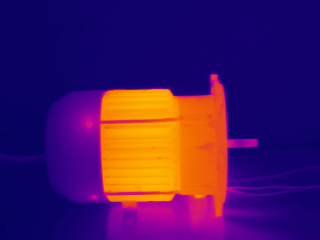

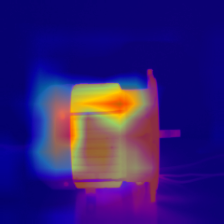

Predicted Class Label: class3


In [ ]:
# Load the test image (replace 'test_image_path' with the actual path to your test image)
test_image_path = '/content/drive/MyDrive/215.bmp'
test_image = cv2.imread(test_image_path)
resized_test_image = cv2.resize(test_image, image_size)

# Generate Guided Grad-CAM image for the test image
guided_cam_test_image = generate_guided_grad_cam(resized_test_image)

# Preprocess the guided test image for the CNN model
guided_test_image_preprocessed = guided_cam_test_image / 255.0

# Expand dimensions to match the CNN model's input shape
guided_test_image_preprocessed = np.expand_dims(guided_test_image_preprocessed, axis=0)

# Predict class probabilities using the trained CNN model
test_probabilities = cnn_model.predict(guided_test_image_preprocessed)

# Get the predicted class label
predicted_class_index = np.argmax(test_probabilities)
predicted_class_label = class_labels[predicted_class_index]

# Display the original test image and Guided Grad-CAM image
cv2_imshow(test_image)
cv2_imshow(guided_cam_test_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Print the predicted class label
print(f'Predicted Class Label: {predicted_class_label}')


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

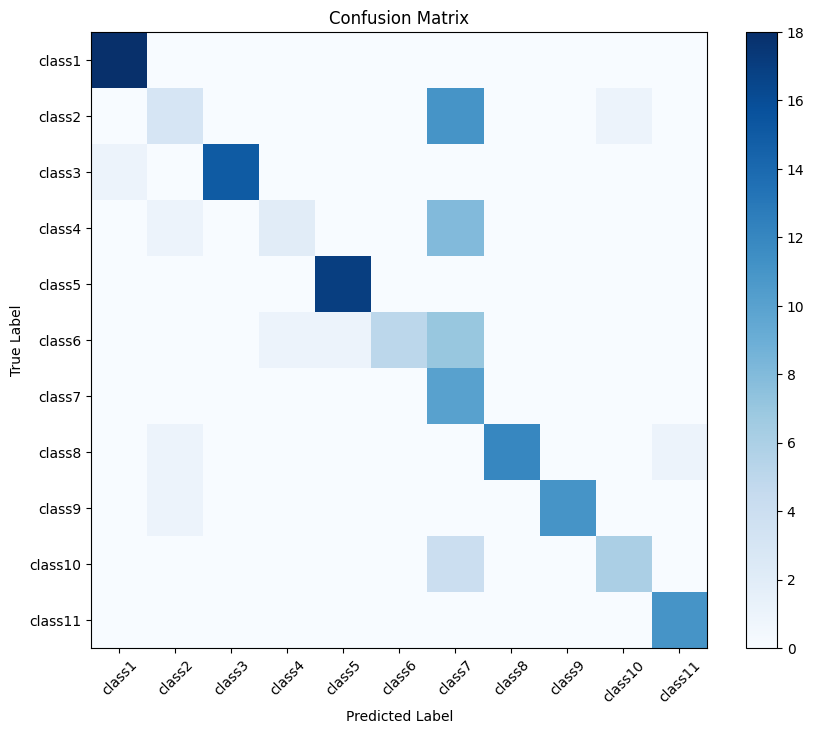

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(guided_test_labels, test_predictions_softmax)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Generate the classification report
class_report = classification_report(guided_test_labels, test_predictions_softmax, target_names=class_labels)

# Print the classification report
print('Classification Report:')
print(class_report)


Classification Report:
              precision    recall  f1-score   support

      class1       0.95      1.00      0.97        18
      class2       0.50      0.20      0.29        15
      class3       1.00      0.94      0.97        16
      class4       0.67      0.18      0.29        11
      class5       0.94      1.00      0.97        17
      class6       1.00      0.36      0.53        14
      class7       0.25      1.00      0.40        10
      class8       1.00      0.86      0.92        14
      class9       1.00      0.92      0.96        12
     class10       0.86      0.60      0.71        10
     class11       0.92      1.00      0.96        11

    accuracy                           0.74       148
   macro avg       0.83      0.73      0.72       148
weighted avg       0.85      0.74      0.75       148



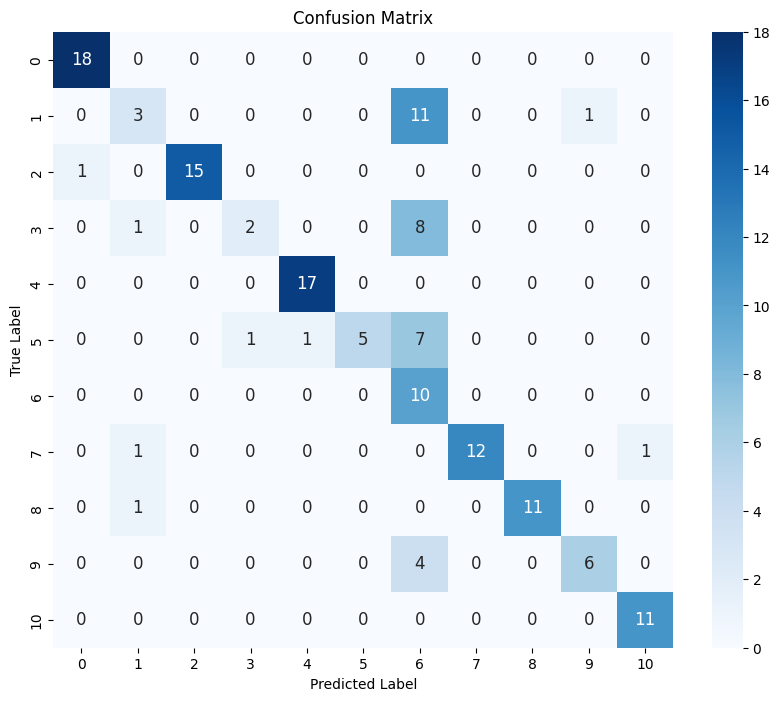

In [ ]:
import seaborn as sns

# Assuming conf_matrix is your confusion matrix

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


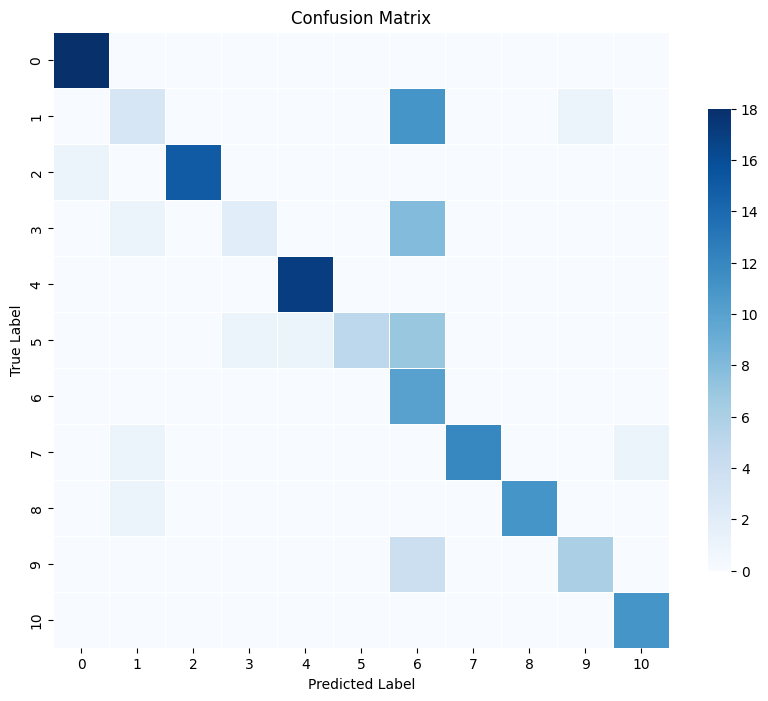

In [ ]:
import seaborn as sns  # Import seaborn for better visualization

# Generate the confusion matrix
conf_matrix = confusion_matrix(guided_test_labels, test_predictions_softmax)

# Display the confusion matrix as a heatmap with lines
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=False, cmap=plt.cm.Blues, linewidths=.5, square=True, cbar_kws={"shrink": 0.75})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


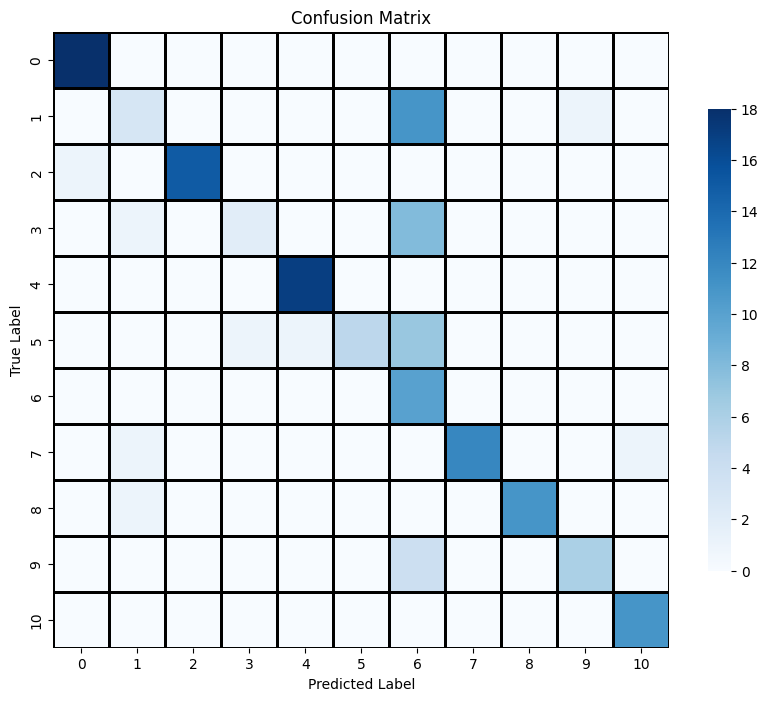

In [ ]:
import seaborn as sns  # Import seaborn for better visualization

# Generate the confusion matrix
conf_matrix = confusion_matrix(guided_test_labels, test_predictions_softmax)

# Display the confusion matrix as a heatmap with black grid lines
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=False, cmap=plt.cm.Blues, linewidths=.5, square=True, cbar_kws={"shrink": 0.75}, linecolor='black', linewidth=1)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
